

# VARIATIONS TEMPORELLES DU BRUIT EN ANTARCTIQUE

---

**Description du Notebook :**
> Dans ce notebook est étudié comment le bruit sismique à évolué avec les différentes mesures sanitaires mises en place par le gouvernement.


---
# Importation des modules

In [2]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
# 1. Récupération des données

### Paramètres initiaux

In [3]:
### Paramètres généraux
load_data = False              # Recalculer les PPSDs et le déplacement RMS
freqs = [(2.0,8.0)]          # Bandes de fréquences à étudier 
st_file = "DATA/st_metadata/stations_antarctic.txt"  # Fichier de stations
noise_input_data = "B:/SeismicNoiseData/"
timeseries_data = "Files/noise_timeseries/"
PPSD_FOLDER  = "C:/Users/Arnaud/Desktop/Travail/Projet de Recherche/SeismicNoiseData/PPSD"
DRMS_FOLDER  = "C:/Users/Arnaud/Desktop/Travail/Projet de Recherche/SeismicNoiseData/DRMS"
MSEED_FOLDER = "C:/Users/Arnaud/Desktop/Travail/Projet de Recherche/SeismicNoiseData/MSEED"
FIG_FOLDER = "RESULTS"
tStart = "2019-01-01"
tEnd = "2019-12-31"

### Conversion des périodes en UTCDateTime
periods = [[UTCDateTime(tStart), UTCDateTime(tEnd)]]

### Récupération des PPSDs et du déplacement RMS

In [4]:
st_name = np.loadtxt(st_file, dtype=str)
# st_name = ["G.CCD.00.HHZ"]   # Station à étudier
dRMS = {}
for st_str in st_name:
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dRMS[st_str] = dataframe
    except:
        pass
st_name = list(dRMS.keys())

In [5]:
dRMS.keys()

dict_keys(['G.CCD.00.BHZ'])

---
# 2. Variations horaires du bruit

## 2.1 Calcul de variations sur toute la période donnée

#### Tags à afficher sur le graphique

In [6]:
# à changer selon ce que l'on veut

tags = [
    ("2019-03-01", 6, "hiver"),
    ("2019-10-01", 6, "été"),
]

In [7]:
### Calcul de la variation du bruit
k = 1
for st_str in st_name:
    print("{}/{}    {}".format(k, len(st_name), st_str))
    for freq in dRMS[st_str].columns:

        try:
            noise = dRMS[st_str][freq]  # Série temporelle du bruit
        except:
            continue
        t, h, noise_matrix = hourly_var(noise, periods)
        grid = noise_matrix * 1e9  # Données en [nm]

        ### Mise en graphique de la variation du bruit
        plt.figure(figsize=(16, 8))
        plt.pcolormesh(t, h+0.25, grid)
        plt.clim(np.nanquantile(grid, 0.05), np.nanquantile(grid, 0.95))
        plt.colorbar(label="Déplacement [nm]")

        ### Affichage des tags
        for (date, hour, text) in tags:
            # plt.scatter(np.datetime64(date), hour, zorder=50, s=40, color="red", edgecolors="white")
            plt.axvline(np.datetime64(date), zorder=50, color="white", ls="-")
            plt.text(np.datetime64(date)-8, 0.75, text, color="white", fontsize="medium", rotation=90)   # Confinement 1

        ### Configuration de l'axe vertical
        plt.ylabel("Heure locale")
        y_ticks = ["%ih" % j for j in range(1, 24)]
        y_loc = [j for j in range(1, 24)]
        plt.yticks(y_loc, y_ticks)
        plt.title("{} - [{}] Hz".format(st_str, freq))
        folder_path = FIG_FOLDER + "/ant_hourly_variations/" + st_str

        if not os.path.exists(folder_path): os.makedirs(folder_path)
        plt.savefig("{}/hourly_temporal_{}.png".format(folder_path, freq), dpi=150)
        plt.close()
        plt.clf()
        
    k += 1

1/1    G.CCD.00.BHZ


<Figure size 432x288 with 0 Axes>

## 2.2 Calcul de variations horaires sur plusieurs sous-périodes

In [6]:
print(dRMS)

{'G.CCD.00.BHZ':                           2.0-8.0
2010-02-01 07:00:01  1.241170e-09
2010-02-01 07:30:01  1.615380e-09
2010-02-01 08:00:01  9.806277e-10
2010-02-01 08:30:01  9.463418e-10
2010-02-01 09:00:01  1.028675e-09
...                           ...
2020-12-31 21:30:00  8.086703e-11
2020-12-31 22:00:00  5.752790e-11
2020-12-31 22:30:00  4.803620e-11
2020-12-31 23:00:00  6.356195e-11
2020-12-31 23:30:00  5.473277e-11

[190360 rows x 1 columns]}


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999


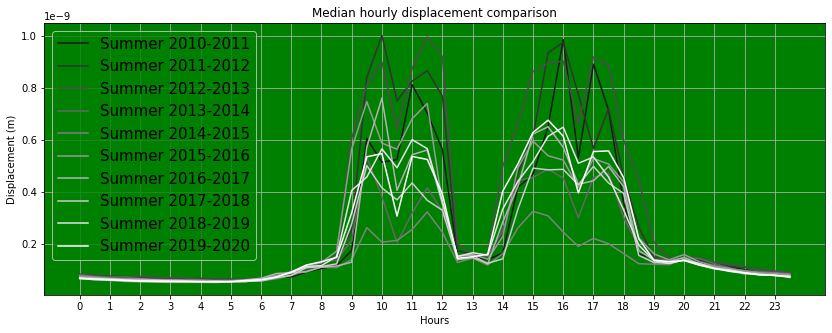

In [37]:
### Paramètres à changer
freq = "2.0-8.0"
st_name = "G.CCD.00.BHZ"
periods = [[[UTCDateTime("2010-10-01"),UTCDateTime("2011-03-01")]],[[UTCDateTime("2011-10-01"),UTCDateTime("2012-03-01")]],[[UTCDateTime("2012-10-01"),UTCDateTime("2013-03-01")]],[[UTCDateTime("2013-10-01"),UTCDateTime("2014-03-01")]],[[UTCDateTime("2014-10-01"),UTCDateTime("2015-03-01")]],[[UTCDateTime("2015-10-01"),UTCDateTime("2016-03-01")]],[[UTCDateTime("2016-10-01"),UTCDateTime("2017-03-01")]],[[UTCDateTime("2017-10-01"),UTCDateTime("2018-03-01")]],[[UTCDateTime("2018-10-01"),UTCDateTime("2019-03-01")]],[[UTCDateTime("2019-10-01"),UTCDateTime("2020-03-01")]]]
###
new_median=[]

for i in periods :

    name = "{}{}_{}".format(st_name, i[0][0].strftime('%Y-%m-%d'), i[0][1].strftime('%Y-%m-%d'))
    noise = dRMS[st_name][freq]
    t, h, noise_matrix = hourly_var(noise, i)
    median1 = np.nanmedian(noise_matrix, axis=1)
    new_median.append(median1.tolist()[33:] + median1.tolist()[0:33])


plt.rcParams['figure.figsize'] = 14, 5
plt.rcParams["axes.facecolor"] = 'g'
plt.title('Median hourly displacement comparison')
plt.xlabel('Hours')
plt.ylabel('Displacement (m)' )
c1=2010
colors=0
for i in new_median :
    c2=c1
    c1=c1+1
    colors=colors+0.10
    col=str(colors)
    print(col)
    plt.plot(h,i,label='Summer '+str(c2)+ '-' +str(c1),color=col)

#plt.plot(test3,test2,color='r', linewidth=2.5,linestyle="--",label='')
plt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))
plt.grid()
plt.legend(fontsize=15)
#plt.savefig('Median_hourly_displacement.png')
plt.show()

# Version France Flavien (pas fonctionnel)

In [11]:
subperiods = [
    ["2010-01-01", "2010-05-31", "début", "red"],
    ["2010-06-01", "2010-12-31", "début", "blue"],
    ["2011-01-01", "2011-12-31", "début", "green"]
]

In [12]:
k = 1

for st_str in st_name:
    print("{}/{}    {}".format(k, len(st_name), st_str))
    for freq in dRMS[st_str].columns:

        try:
            noise = dRMS[st_str][freq]  # Série temporelle du bruit
        except:
            continue

        t, h, noise_matrix = hourly_var(noise, periods)
        grid = noise_matrix * 1e9  # Données en [nm]
        
        # h = np.append(h[8:], h[:8])

        ### Calcul du bruit pour que sous-période
        plt.figure(figsize=(12, 6))
        for i, value in enumerate(subperiods):
            time1 = np.datetime64(subperiods[i][0])
            time2 = np.datetime64(subperiods[i][1])
            print(time1,time2)
            color = subperiods[i][3]
            label = "{} to {} : {}".format(subperiods[i][0], subperiods[i][1], subperiods[i][2])
            k1 = np.where(t == time1)[0][0]
            k2 = np.where(t == time2)[0][0]
            

            median = np.nanmedian(grid[:,k1:k2], axis=1)
            median = np.append(median[8:], median[:8])
            
            #if subperiods[i][2]=="No lockdown": plt.plot(h, median, label=label, color=color, lw=2, ls="--")
            plt.plot(h, median, label=label, color=color, lw=2)

        ### Mise en graphique
        plt.tick_params(direction="in", which="both", top=True, right=True)
        plt.title("{} - [{}] Hz".format(st_str,freq))
        plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
        # plt.ylabel("Median displacement [nm]")
        plt.xlim([0, 23.5])
        h_tick = np.append(np.arange(4, 23, 2), np.arange(0, 4, 2))
        h_label = ["4h","6h","8h","10h","12h","14h","16h","18h","20h","22h", "0h", "2h"]
        plt.xticks(np.arange(0, 23, 2), h_label)
        # plt.xticks(np.arange(0, 23, 2), ["0h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h"])

        plt.legend(loc="upper left",   # Position of legend
                   borderaxespad=0.2,    # Small spacing around legend box
                   bbox_to_anchor=(-0.1, -0.1),
                   ncol=3)

        plt.tight_layout()

        folder_path = FIG_FOLDER + "/ant_hourly_variations/" + st_str

        if not os.path.exists(folder_path): os.makedirs(folder_path)

        plt.savefig("{}/hourly_periods_{}.png".format(folder_path, freq), dpi=150)
        plt.close()
        plt.clf()

    k += 1

1/12    G


KeyError: 'G'